In [1]:
import torch
import transformers
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os
import pprint
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
transformers.__version__, torch.__version__

('4.40.2', '2.1.1')

In [3]:
# Device and paths:
device = 'cuda'
physionet_dir = '/datasets/work/hb-mlaifsp-mm/work/archive/physionet.org/files'  # Where MIMIC-CXR, MIMIC-CXR-JPG, and MIMIC-IV-ED are stored.
dataset_dir = '/scratch3/nic261/datasets'  # Some outputs of prepare_data() will be stored here.
database_path = '/scratch3/nic261/database/cxrmate_ed.db'  # The DuckDB database used to manage the tables of the dataset will be saved here.
mimic_cxr_jpg_dir = '/scratch3/nic261/datasets/physionet.org/files/mimic-cxr-jpg/2.0.0/files'  # The path to the JPG images of MIMIC-CXR-JPG. This could be different to physionet_dir to leverage faster storage.

In [4]:
# Download model checkpoint:
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-ed', trust_remote_code=True).to(device=device)
model.eval()

# Download tokenizer:
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained('aehrc/cxrmate-ed')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/scratch3/nic261/environments/cxrmate_ed/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Image transforms:
image_size = 384
test_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=3),
        v2.Resize(
            size=image_size, 
            antialias=True,
            interpolation=v2.InterpolationMode.BICUBIC,
        ),
        v2.CenterCrop(size=[image_size, image_size]),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

In [6]:
# Prepare the MIMIC-CXR & MIMIC-IV-ED dataset:
model.prepare_data(
    physionet_dir=physionet_dir,
    dataset_dir=dataset_dir,
    database_path=database_path,
)

# Get the test set dataset & dataloader:
test_set = model.get_dataset('test', test_transforms, database_path, mimic_cxr_jpg_dir)
test_dataloader = DataLoader(
    test_set,
    batch_size=1, 
    num_workers=5,
    shuffle=True,  # Shuffle so that a different example is shown everytime the notebook is ran.
    collate_fn=model.collate_fn,
    pin_memory=True,
)

No. of examples: 1624.
No. of training dicom_ids, study_ids, & subject_ids: 2872, 1624, & 280.


In [7]:
# Get an example:
batch = next(iter(test_dataloader))
        
# Show the batch:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(batch)

{ 'edstays_index_value_feats': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 1.]]]),
  'edstays_index_value_mask': tensor([[1]], dtype=torch.int32),
  'edstays_index_value_time_delta': tensor([[[0.6826]]]),
  'edstays_index_value_token_type_ids': tensor([[1]]),
  'findings': [ 'The right Port-A-Cath reservoir projects over the right chest '
                'and is currently accessed; the catheter tip ends in the lower '
                'SVC. There has been interval placement of sternotomy wires, '
                'which are intact. The heart size is within normal limits and '
                'the mediastinal hilar contours do not appear widened. '
                'Calcified AP window node again seen. The lungs demonstrate '
                'left bailar opacity which is more linear in configuration on '
                'the lateral view. There is no

/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


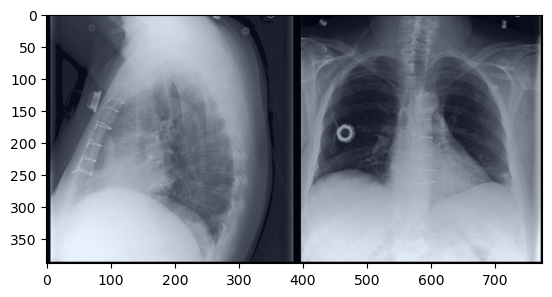

In [8]:
# Show the images for the study:
plt.imshow(make_grid(batch['images'][0], normalize=True).permute(1, 2, 0))

In [9]:
# Move tensors in the batch to the device:
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        batch[key] = value.to(device)

In [10]:
# Convert the patient data in the batch into embeddings:
inputs_embeds, attention_mask, token_type_ids, position_ids, bos_token_ids = model.prepare_inputs(tokenizer=tokenizer, **batch)
    
# Generate reports:
output_ids = model.generate(
    input_ids=bos_token_ids,
    decoder_inputs_embeds=inputs_embeds,
    decoder_token_type_ids=token_type_ids,
    prompt_attention_mask=attention_mask,
    prompt_position_ids=position_ids,
    special_token_ids=[tokenizer.sep_token_id],
    token_type_id_sections=model.decoder.config.section_ids,
    max_length=256,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    num_beams=4,
    return_dict_in_generate=True,
    use_cache=True,
)['sequences']


In [11]:
# Findings and impression section:
findings, impression = model.split_and_decode_sections(output_ids, [tokenizer.sep_token_id, tokenizer.eos_token_id], tokenizer)
for i,j in zip(findings, impression):
    print(f'Findings:\t{i}\nImpression:\t{j}\n\n')

Findings:	PA and lateral views of the chest. Right-sided Port-A-Cath tip terminates in the upper SVC. The patient is status post median sternotomy and CABG. The heart size is normal. The mediastinal and hilar contours are unchanged. There is no pulmonary edema. There are linear opacities at the left lung base, which may represent atelectasis. There is linear opacity in the left lung base. No focal consolidation. No pleural effusion or pneumothorax is seen.
Impression:	No acute cardiopulmonary process.


